In [1]:
#Import libraries
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
#Import and view data set
fname = 'ForexAnalysis.csv'
df = pd.read_csv(fname)
print(df.dtypes)
df.head()

date               object
china_cpi         float64
uk_cpi            float64
us_cpi            float64
china_ir          float64
us_ir             float64
uk_ir             float64
brent             float64
wti               float64
us_china_forex    float64
us_uk_forex       float64
uk_bop            float64
us_bop            float64
china_bop         float64
dtype: object


,date,china_cpi,uk_cpi,us_cpi,china_ir,us_ir,uk_ir,brent,wti,us_china_forex,us_uk_forex,uk_bop,us_bop,china_bop
0,1/1/90,NaN,52.8,54.3,9.0,8.23,14.875,21.25,22.96,0.2112,1.6512,NaN,NaN,NaN
1,2/1/90,NaN,53.3,54.5,9.0,8.24,14.875,19.93,22.12,0.2112,1.6961,NaN,NaN,NaN
2,3/1/90,NaN,53.5,54.8,9.0,8.28,14.875,18.37,20.41,0.2112,1.6245,NaN,NaN,NaN
3,4/1/90,NaN,54.8,54.9,9.0,8.26,14.875,16.49,18.43,0.2112,1.6372,NaN,NaN,NaN
4,5/1/90,NaN,55.4,55.0,9.0,8.18,14.875,16.34,18.25,0.2112,1.6774,NaN,NaN,NaN


In [3]:
#Convert Date Column to datetime type and set it as index
df['date']=df['date'].astype('datetime64')
print(df.dtypes)
df.set_index('date',inplace=True)

date              datetime64[ns]
china_cpi                float64
uk_cpi                   float64
us_cpi                   float64
china_ir                 float64
us_ir                    float64
uk_ir                    float64
brent                    float64
wti                      float64
us_china_forex           float64
us_uk_forex              float64
uk_bop                   float64
us_bop                   float64
china_bop                float64
dtype: object


In [4]:
df.describe()

,china_cpi,uk_cpi,us_cpi,china_ir,us_ir,uk_ir,brent,wti,us_china_forex,us_uk_forex,uk_bop,us_bop,china_bop
count,325.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,252.000000,252.000000,252.000000
mean,81.933538,82.256787,82.525762,4.755263,2.900720,4.197022,49.246762,47.771269,0.142689,1.604053,-6968.112956,-40800.115080,13608.982209
std,16.156517,15.131335,16.152467,2.627380,2.364899,3.549994,32.904923,29.208501,0.023856,0.184311,3597.609962,11964.853966,10451.887271
min,41.600000,52.800000,54.300000,2.700000,0.070000,0.250000,9.800000,11.310000,0.114600,1.216000,-15818.510000,-71923.000000,-6911.620000
25%,71.300000,70.700000,68.300000,2.900000,0.380000,0.500000,19.730000,21.240000,0.120800,1.496800,-8953.336667,-45646.333335,3371.127833
50%,77.000000,79.100000,81.700000,3.250000,2.420000,4.500000,41.253043,40.711364,0.144500,1.593900,-6861.620000,-36861.000000,12520.806665
75%,96.900000,96.700000,97.600000,7.200000,5.240000,5.937500,70.526522,67.988696,0.158100,1.684200,-3705.068333,-33024.083332,21819.682498
max,113.600000,109.400000,110.300000,10.440000,8.290000,14.875000,133.899130,133.927143,0.211200,2.070100,-1247.539333,-20280.333330,39697.800000


In [5]:
#Identify missing values in each column
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

china_cpi
False    325
True      36
Name: china_cpi, dtype: int64

uk_cpi
False    361
Name: uk_cpi, dtype: int64

us_cpi
False    361
Name: us_cpi, dtype: int64

china_ir
False    361
Name: china_ir, dtype: int64

us_ir
False    361
Name: us_ir, dtype: int64

uk_ir
False    361
Name: uk_ir, dtype: int64

brent
False    361
Name: brent, dtype: int64

wti
False    361
Name: wti, dtype: int64

us_china_forex
False    361
Name: us_china_forex, dtype: int64

us_uk_forex
False    361
Name: us_uk_forex, dtype: int64

uk_bop
False    252
True     109
Name: uk_bop, dtype: int64

us_bop
False    252
True     109
Name: us_bop, dtype: int64

china_bop
False    252
True     109
Name: china_bop, dtype: int64



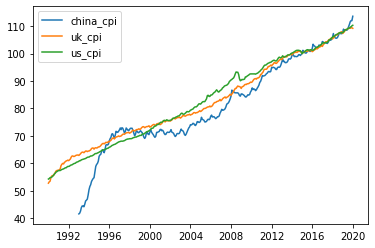

In [6]:
#'china_cpi' is missing 3 years of data.
#Try extrapolating backwards using a best fit line
#To figure out what function we should use, let's look at the line graphs of the 'cpi' variables
plt.plot(df['china_cpi'],label='china_cpi')
plt.plot(df['uk_cpi'],label='uk_cpi')
plt.plot(df['us_cpi'],label='us_cpi')
plt.legend()

In [7]:
#While China's cpi graph follows a slightly different curve, the graphs are mostly linear
#Consequently, let's keep it simple and extrapolate data with a linear model
#Define the function
#Create a separate dataframe that resets the index to integers (dates cannot be used) and drops all NaN values.
#I also removed the balance of payments data because those columns are missing substantially more than everything else. 
def func(x,a,b):
    return a * x + b

fit_df = df.drop(columns=['uk_bop','china_bop','us_bop'])
fit_df = fit_df.dropna()
fit_df = fit_df.reset_index()
fit_df.drop('date',axis=1,inplace=True)
fit_df.head()

,china_cpi,uk_cpi,us_cpi,china_ir,us_ir,uk_ir,brent,wti,us_china_forex,us_uk_forex
0,41.6,62.9,60.8,7.20,3.02,5.875,17.35,19.06,0.1730,1.5325
1,41.9,63.2,61.0,7.20,3.03,5.875,18.48,20.04,0.1728,1.4395
2,42.6,63.5,61.0,7.20,3.07,5.875,18.75,20.32,0.1741,1.4617
3,43.9,63.9,61.3,7.20,2.96,5.875,18.63,20.26,0.1748,1.5447
4,44.5,64.1,61.4,8.46,3.00,5.875,18.51,19.94,0.1742,1.5477


Extrapolated data:


<ipython-input-8-3c66984c62b9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['china_cpi'][z] = func(z, *col_params['china_cpi'])


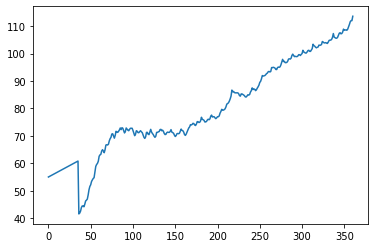

In [8]:
guess = (0.5,0.5)
col_params = {}

# Get x & y
x = fit_df.index.astype(float).values
y = fit_df['china_cpi'].values
# Curve fit 'china_cpi' and get curve parameters
params = curve_fit(func, x, y, guess)
# Store optimized parameters
col_params['china_cpi'] = params[0]

# Extrapolate column
# Get the index values for NaNs in the column
df = df.reset_index()
z = df[pd.isnull(df['china_cpi'])].index.astype(float).values
# Extrapolate those points with the fitted function
df['china_cpi'][z] = func(z, *col_params['china_cpi'])

# Display result
print ('Extrapolated data:')
df[['date','china_cpi']].head(50)
plt.plot(df['china_cpi'])

In [9]:
#The extrapolated data is probably not an accurate representation of what China's CPI was between 1990-1992
#To fix this problem, we could curve fit the data to functions of higher orders
#However, I'm going to leave it as is because I'm going to end up removing all rows with missing data in a little bit.
#These extrapolated points will get dropped anyways. 
#Let's set the index back to the Date
df.set_index('date',inplace=True)

In [10]:
df.head()

,china_cpi,uk_cpi,us_cpi,china_ir,us_ir,uk_ir,brent,wti,us_china_forex,us_uk_forex,uk_bop,us_bop,china_bop
date,,,,,,,,,,,,,
1990-01-01,55.044778,52.8,54.3,9.0,8.23,14.875,21.25,22.96,0.2112,1.6512,NaN,NaN,NaN
1990-02-01,55.210758,53.3,54.5,9.0,8.24,14.875,19.93,22.12,0.2112,1.6961,NaN,NaN,NaN
1990-03-01,55.376738,53.5,54.8,9.0,8.28,14.875,18.37,20.41,0.2112,1.6245,NaN,NaN,NaN
1990-04-01,55.542718,54.8,54.9,9.0,8.26,14.875,16.49,18.43,0.2112,1.6372,NaN,NaN,NaN
1990-05-01,55.708698,55.4,55.0,9.0,8.18,14.875,16.34,18.25,0.2112,1.6774,NaN,NaN,NaN


In [11]:
#Before checking correlations and fitting regression models, normalize the data
for column in df.columns.values.tolist():
    df[column] = df[column]/df[column].max()
df.head() 

,china_cpi,uk_cpi,us_cpi,china_ir,us_ir,uk_ir,brent,wti,us_china_forex,us_uk_forex,uk_bop,us_bop,china_bop
date,,,,,,,,,,,,,
1990-01-01,0.484549,0.482633,0.492294,0.862069,0.992762,1.0,0.158702,0.171436,1.0,0.797643,NaN,NaN,NaN
1990-02-01,0.486010,0.487203,0.494107,0.862069,0.993969,1.0,0.148843,0.165164,1.0,0.819332,NaN,NaN,NaN
1990-03-01,0.487471,0.489031,0.496827,0.862069,0.998794,1.0,0.137193,0.152396,1.0,0.784745,NaN,NaN,NaN
1990-04-01,0.488932,0.500914,0.497733,0.862069,0.996381,1.0,0.123152,0.137612,1.0,0.790880,NaN,NaN,NaN
1990-05-01,0.490393,0.506399,0.498640,0.862069,0.986731,1.0,0.122032,0.136268,1.0,0.810299,NaN,NaN,NaN


In [12]:
#Create calculated fields for inflation and interest rate spreads
df['us_china_cpispread']=df['us_cpi']-df['china_cpi']
df['us_uk_cpispread']=df['us_cpi']-df['uk_cpi']
df['us_china_irspread']=df['us_ir']-df['china_ir']
df['us_uk_irspread']=df['us_ir']-df['uk_ir']
df.head()

,china_cpi,uk_cpi,us_cpi,china_ir,us_ir,uk_ir,brent,wti,us_china_forex,us_uk_forex,uk_bop,us_bop,china_bop,us_china_cpispread,us_uk_cpispread,us_china_irspread,us_uk_irspread
date,,,,,,,,,,,,,,,,,
1990-01-01,0.484549,0.482633,0.492294,0.862069,0.992762,1.0,0.158702,0.171436,1.0,0.797643,NaN,NaN,NaN,0.007745,0.009661,0.130693,-0.007238
1990-02-01,0.486010,0.487203,0.494107,0.862069,0.993969,1.0,0.148843,0.165164,1.0,0.819332,NaN,NaN,NaN,0.008097,0.006904,0.131900,-0.006031
1990-03-01,0.487471,0.489031,0.496827,0.862069,0.998794,1.0,0.137193,0.152396,1.0,0.784745,NaN,NaN,NaN,0.009356,0.007796,0.136725,-0.001206
1990-04-01,0.488932,0.500914,0.497733,0.862069,0.996381,1.0,0.123152,0.137612,1.0,0.790880,NaN,NaN,NaN,0.008801,-0.003181,0.134312,-0.003619
1990-05-01,0.490393,0.506399,0.498640,0.862069,0.986731,1.0,0.122032,0.136268,1.0,0.810299,NaN,NaN,NaN,0.008247,-0.007758,0.124662,-0.013269


In [13]:
#Calculate Pearson Correlation Coefficients and P-values
#To use this method, we need to remove all NaN values. This will drop the first 109 data points
df.dropna(inplace=True)
chinap = df.drop(['china_cpi','uk_cpi','us_cpi','china_ir','uk_ir','us_ir','us_uk_irspread','us_uk_forex','us_uk_cpispread','uk_bop'],axis=1)
ukp = df.drop(['china_cpi','uk_cpi','us_cpi','china_ir','uk_ir','us_ir','us_china_irspread','us_china_forex','us_china_cpispread','china_bop'],axis=1)
print('US/China FX')
for column in chinap:
    pearson_coef, p_value = stats.pearsonr(chinap[column], chinap['us_china_forex'])
    print(column)
    print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
    print("")
print('US/UK FX')
for column in ukp:
    pearson_coef, p_value = stats.pearsonr(ukp[column], ukp['us_uk_forex'])
    print(column)
    print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
    print("")

US/China FX
brent
The Pearson Correlation Coefficient is 0.730054555354525  with a P-value of P = 3.1963792871411947e-43

wti
The Pearson Correlation Coefficient is 0.6748839854745764  with a P-value of P = 7.484391290217595e-35

us_china_forex
The Pearson Correlation Coefficient is 1.0  with a P-value of P = 0.0

us_bop
The Pearson Correlation Coefficient is -0.3550871983830824  with a P-value of P = 6.6758693575744484e-09

china_bop
The Pearson Correlation Coefficient is 0.45587511434147554  with a P-value of P = 2.4557790491075587e-14

us_china_cpispread
The Pearson Correlation Coefficient is -0.41912241695789654  with a P-value of P = 3.850438542038774e-12

us_china_irspread
The Pearson Correlation Coefficient is -0.7356523114585448  with a P-value of P = 3.46094809659247e-44

US/UK FX
brent
The Pearson Correlation Coefficient is 0.20723821315039961  with a P-value of P = 0.0009347955516920119

wti
The Pearson Correlation Coefficient is 0.29304404443499904  with a P-value of P = 2.

In [14]:
#View these correlations in a table
df[['us_uk_forex','us_uk_cpispread','us_uk_irspread','us_bop','uk_bop','brent','wti']].corr()

,us_uk_forex,us_uk_cpispread,us_uk_irspread,us_bop,uk_bop,brent,wti
us_uk_forex,1.000000,0.712695,-0.083830,0.604115,-0.133733,0.207238,0.293044
us_uk_cpispread,0.712695,1.000000,-0.139886,0.785808,-0.012515,0.331473,0.431666
us_uk_irspread,-0.083830,-0.139886,1.000000,0.145652,-0.087896,-0.214392,-0.220077
us_bop,0.604115,0.785808,0.145652,1.000000,-0.058441,0.071006,0.146497
uk_bop,-0.133733,-0.012515,-0.087896,-0.058441,1.000000,0.411304,0.401237
brent,0.207238,0.331473,-0.214392,0.071006,0.411304,1.000000,0.984609
wti,0.293044,0.431666,-0.220077,0.146497,0.401237,0.984609,1.000000


In [19]:
df[['us_china_forex','us_china_cpispread','us_china_irspread','us_bop','china_bop','brent','wti']].corr()

,us_china_forex,us_china_cpispread,us_china_irspread,us_bop,china_bop,brent,wti
us_china_forex,1.000000,-0.419122,-0.735652,-0.355087,0.455875,0.730055,0.674884
us_china_cpispread,-0.419122,1.000000,0.197257,0.671764,0.200612,0.065195,0.153423
us_china_irspread,-0.735652,0.197257,1.000000,0.353933,-0.275217,-0.488071,-0.448662
us_bop,-0.355087,0.671764,0.353933,1.000000,0.318257,0.071006,0.146497
china_bop,0.455875,0.200612,-0.275217,0.318257,1.000000,0.468560,0.508147
brent,0.730055,0.065195,-0.488071,0.071006,0.468560,1.000000,0.984609
wti,0.674884,0.153423,-0.448662,0.146497,0.508147,0.984609,1.000000


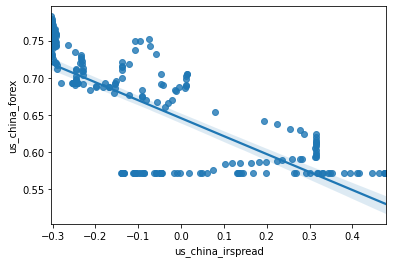

In [20]:
#View these relationships in scatter plots
sns.regplot(x='us_china_irspread',y='us_china_forex',data=df)

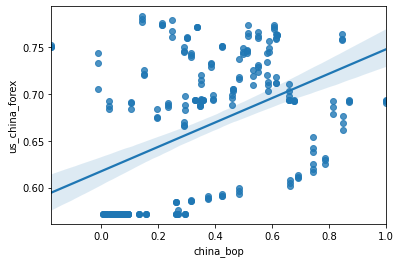

In [21]:
sns.regplot(x='china_bop',y='us_china_forex',data=df)

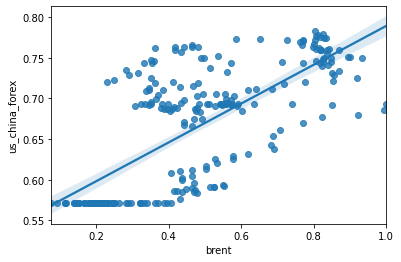

In [22]:
sns.regplot(x='brent',y='us_china_forex',data=df)

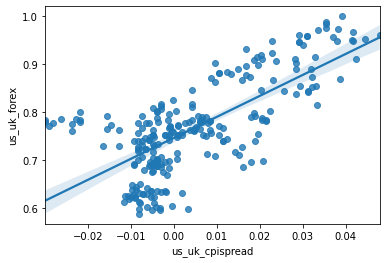

In [23]:
sns.regplot(x='us_uk_cpispread',y='us_uk_forex',data=df)

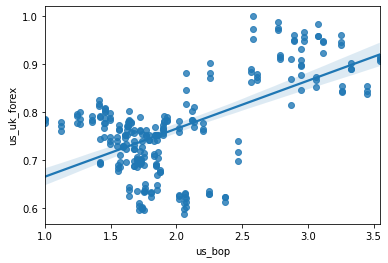

In [24]:
sns.regplot(x='us_bop',y='us_uk_forex',data=df)

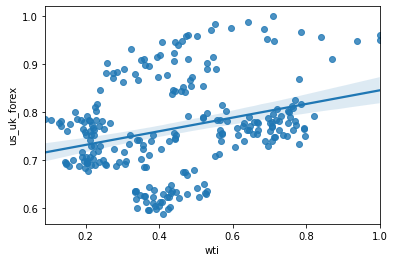

In [25]:
sns.regplot(x='wti',y='us_uk_forex',data=df)

In [47]:
#Since we know which variables are good predictors of FX rates, let's construct a multiple linear regression model for both
#Since Brent Oil and WTI Oil are almost perfectly correlated, it's important that they aren't used in the same model
#Brent Oil has a higher correlation with 'us_china_forex' and WTI Oil has a higher correlation with 'us_uk_forex'
lm = LinearRegression()
chinamlr = df[['brent','us_bop','china_bop','us_china_irspread','us_china_cpispread']]
lm.fit(chinamlr,df['us_china_forex'])
r1 = lm.score(chinamlr,df['us_china_forex'])
print('The R^2 of this model is', r1)

The R^2 of this model is 0.8962487474454266


In [48]:
lm1 = LinearRegression()
ukmlr = df[['wti','us_bop','uk_bop','us_bop','us_uk_cpispread']]
lm1.fit(ukmlr,df['us_uk_forex'])
r2 = lm1.score(ukmlr,df['us_uk_forex'])
print('The R^2 of this model is', r2)

The R^2 of this model is 0.5323304614284614


In [49]:
#The R^2 values are pretty strong. However, using all of our data doesn't leave much room for model evaluation
#Let's also divide our data into testing and training samples and try again
#First, define a distribution plotting function
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Foreign Exchange Rate')
    plt.ylabel('')

    plt.show()
    plt.close()

In [50]:
y_datac = df['us_china_forex']
y_datau = df['us_uk_forex']
x_datac = df.drop(['china_cpi','uk_cpi','us_cpi','china_ir','uk_ir','us_ir','us_uk_irspread','us_uk_forex','us_uk_cpispread','uk_bop','wti'],axis=1)
x_datau = df.drop(['china_cpi','uk_cpi','us_cpi','china_ir','uk_ir','us_ir','us_china_irspread','us_china_forex','us_china_cpispread','china_bop','brent'],axis=1)

In [51]:
#Generate training and testing samples for both models
x_trainc, x_testc, y_trainc, y_testc = train_test_split(x_datac, y_datac, test_size=0.15, random_state=1)
print('US/China')
print("number of test samples :", x_testc.shape[0])
print("number of training samples:",x_trainc.shape[0])
print("")

x_trainu, x_testu, y_trainu, y_testu = train_test_split(x_datau, y_datau, test_size=0.15, random_state=1)
print('US/UK')
print("number of test samples :", x_testu.shape[0])
print("number of training samples:",x_trainu.shape[0])

US/China
number of test samples : 38
number of training samples: 214

US/UK
number of test samples : 38
number of training samples: 214


In [52]:
#Create an MLR model and train it
lr = LinearRegression()
lr.fit(x_trainc[['brent', 'us_china_cpispread', 'us_china_irspread','us_bop','china_bop']], y_trainc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
#Generate predictions with training data
yhat_trainc = lr.predict(x_trainc[['brent', 'us_china_cpispread', 'us_china_irspread','us_bop','china_bop']])
yhat_trainc[0:5]

array([0.55289361, 0.6658585 , 0.71470046, 0.56501935, 0.5758093 ])

In [54]:
#Generate predictions with testing data
yhat_testc = lr.predict(x_testc[['brent', 'us_china_cpispread', 'us_china_irspread','us_bop','china_bop']])
yhat_testc[0:5]

array([0.5993217 , 0.71716515, 0.67486731, 0.74796119, 0.5561182 ])

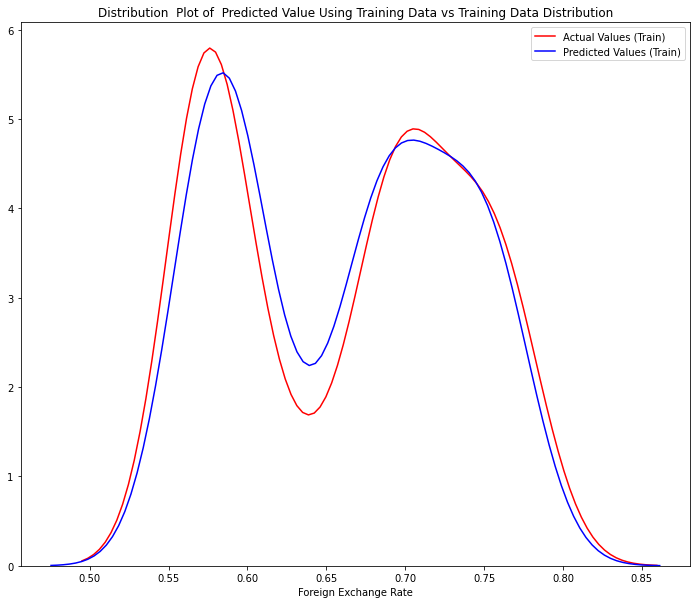

In [55]:
#Examine the distribution of predicted values using training data
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_trainc, yhat_trainc, "Actual Values (Train)", "Predicted Values (Train)", Title)

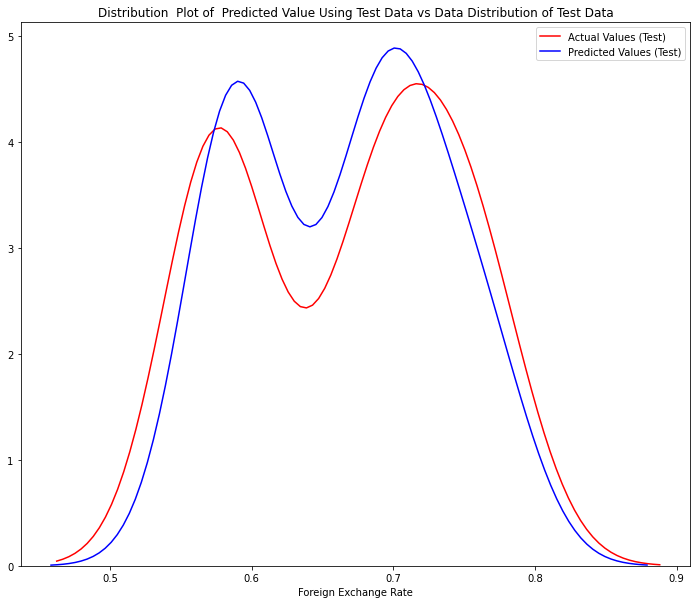

In [56]:
#Evaluate the distribution of predicte values using test data
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_testc,yhat_testc,"Actual Values (Test)","Predicted Values (Test)",Title)

In [57]:
#Repeat these steps for US/UK data
lr.fit(x_trainu[['wti', 'us_uk_cpispread', 'us_uk_irspread','us_bop','uk_bop']], y_trainu)

yhat_trainu = lr.predict(x_trainu[['wti', 'us_uk_cpispread', 'us_uk_irspread','us_bop','uk_bop']])
yhat_trainu[0:5]

yhat_testu = lr.predict(x_testu[['wti', 'us_uk_cpispread', 'us_uk_irspread','us_bop','uk_bop']])
yhat_testu[0:5]

array([0.82035283, 0.77309795, 0.71410359, 0.75015914, 0.88766823])

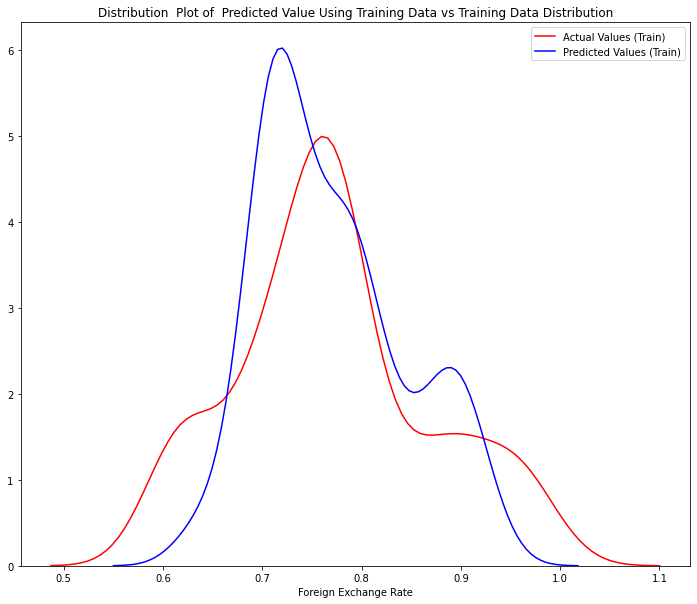

In [58]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_trainu, yhat_trainu, "Actual Values (Train)", "Predicted Values (Train)", Title)

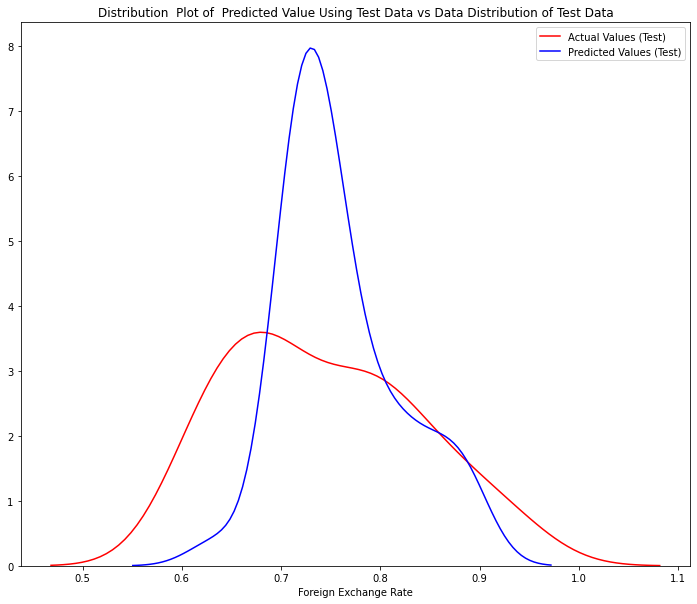

In [59]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_testu,yhat_testu,"Actual Values (Test)","Predicted Values (Test)",Title)

In [60]:
#The model predicted FX rates between the US Dollar and Chinese Yuan (USD/RMB) does well in learning from the training data. 
#Not surprisingly, it performs worse when exposed to new data. However, it's still doing a relatively good job.
#The model predicting FX rates between the US Dollar and Great British Pound (USD/GBP) does not perform particularly well with training data, and even worse when shown test data.
#The next step in this process would be to address the potential underfitting of our model with polynomial transformations
#It's likely that the model predicting USD/RMB performs better because China pegs the value of their currency to the USD.
#Unlike most advanced countries (like the UK), China does not have a floating currency that is determined exclusively by market forces.
#Finally, it's important to note some flaws in these models. Most notably, multicollinearity occurs between our independent variables.
#To avoid this issue with oil prices, we dropped either Brent from the USD/GBP model and WTI from the USD/RMB model
#Since these countries trade with one another, their balance of payments data will be correlated.